# Scalable Vertex Recognition
University of Stuttgart, Institute of Aircraft Systems, Andreas Waldvogel, 2024

A Jupyter Notebook demonstrating how DOMAINES Visualization Verification finds so called scalable vertices in a screenshot of a block diagram. In the case of a Functions Layer of the Open Avionics Architecture Model, this comes down to blue boxes.

Find template on target image block diagram.
The used technology is open CV and template matching. Matplotlib is used for graphs.
Plotly produces nice graphs, however is super computing intensive, especially if 1 Mio pixels need to be calculated. So activate individual plots by setting activate_plotly to True. 

Tested in VS Code using the Jupyter Notebook Plugin

#### Procedure
* Using template matching, a template is searched in a target image.
* A threshold of 60% is used. 
* Boxes of the matched pixels are drawn.
* Only boxes on the foreground are allowed (step probably not needed anymore)
* Individual boxes are composed to super boxes representing the searched tasks.

#### images are removed to save space in the repository

#### Imports
make sure to have installed at least opencv, numpy and matplotlib. plotly is optional, but beautiful.

In [55]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import plotly.graph_objects as go

## Input

In [56]:
activate_plotly = False # turn expensive renderings on and off
threshold = 0.45 # 0.45 to find the upper left recangle

# Define the paths
# target_image_path = '3boxes_labels.png'
# target_image_path = '00_3boxes_labels_scaled.png' # default
# target_image_path = 'door_system.png' # version 1 for paper
target_image_path = 'images/allocations_3.png' # version 2 for paper with scaled vertex
# target_image_path = 'system.png'
# target_image_path = '3boxes_grey_input.png'
# template_image_path = 'task_scaled3.png'
# template_image_path = 'task_white.png'
# template_image_path = 'task.png'
template_image_path = 'images/container.png'
# template_image_path = 'greytemplate.png'

target_img = cv2.imread(target_image_path)
template_img = cv2.imread(template_image_path)



#### Visualization of Input

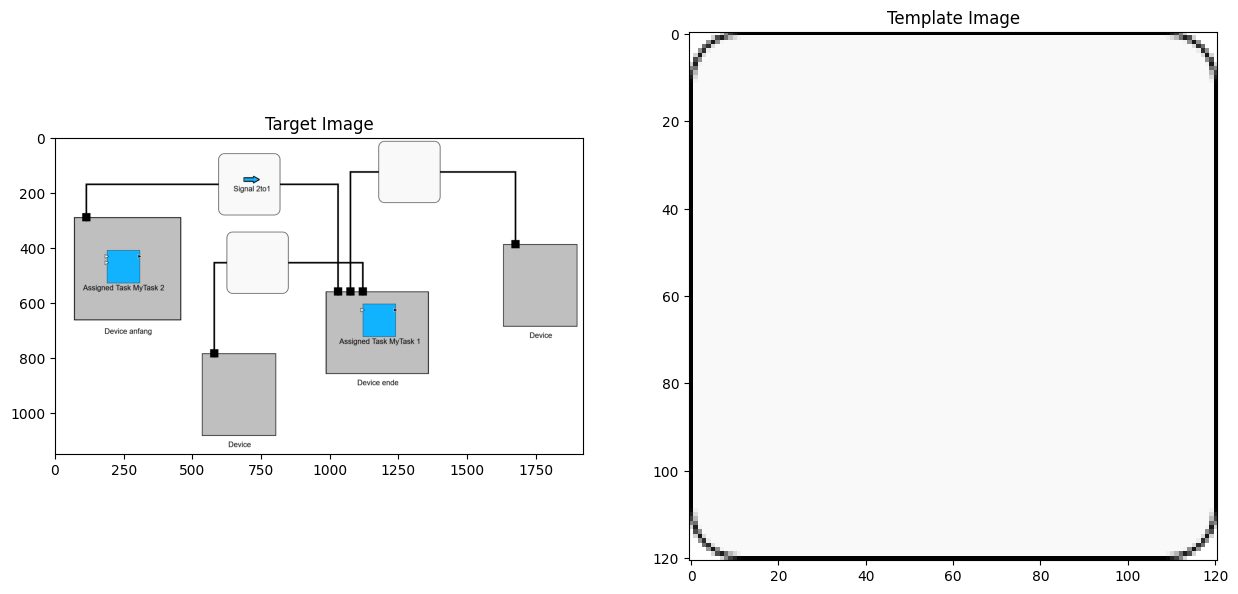

In [57]:
# Draw target image and template image
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB))
ax[0].set_title('Target Image')
ax[1].imshow(cv2.cvtColor(template_img, cv2.COLOR_BGR2RGB))
ax[1].set_title('Template Image')
plt.show()

## Template Matching

Use opencv template matching: https://docs.opencv.org/4.10.0/df/dfb/group__imgproc__object.html

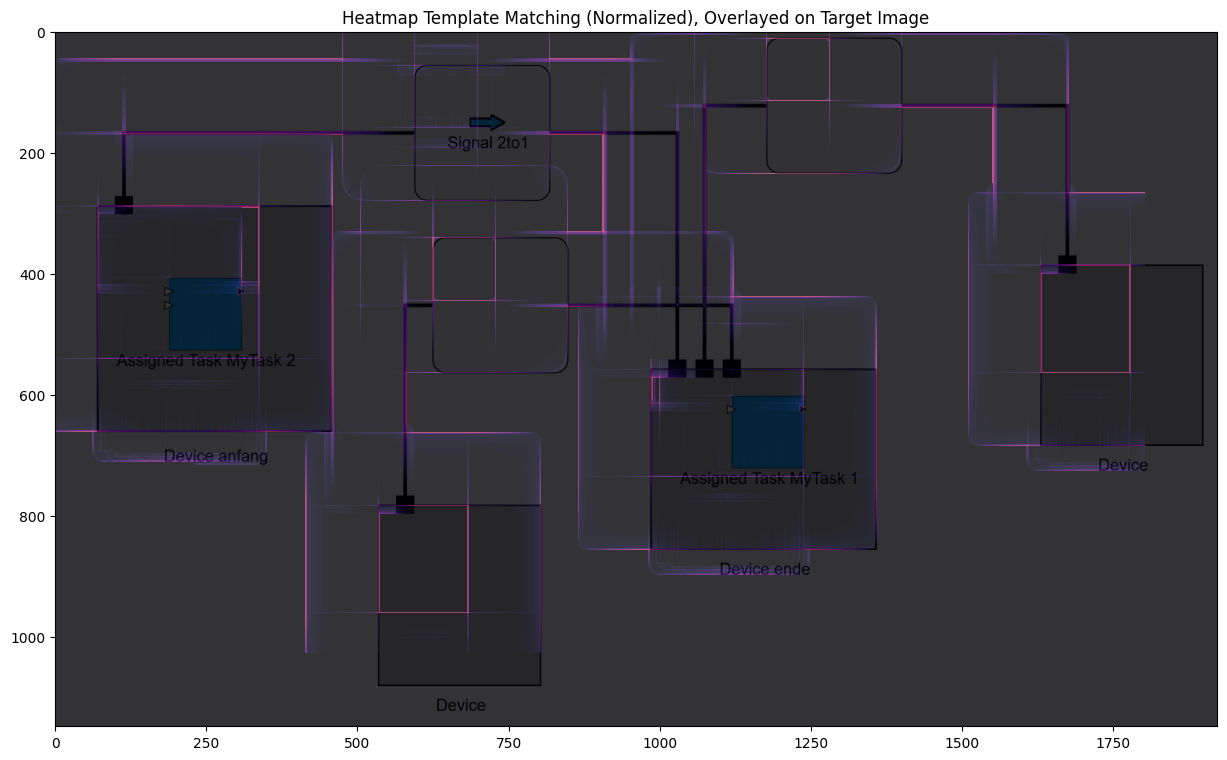

In [58]:
# Apply template matching
res = cv2.matchTemplate(target_img, template_img, cv2.TM_CCOEFF_NORMED)

# Pad the result to match the size of the original image
pad_width = ((0, target_img.shape[0] - res.shape[0]), (0, target_img.shape[1] - res.shape[1]))
res_padded = np.pad(res, pad_width, mode='constant', constant_values=0)

# Overlay the padded result on the original image
plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB))
plt.imshow(res_padded, cmap='inferno', alpha=0.8, interpolation='nearest', vmin=0, vmax=1)  # `alpha` controls the transparency.
plt.title('Heatmap Template Matching (Normalized), Overlayed on Target Image')
plt.show()

#### Visualization of Template Matching over Target Image

res seems to be smaller than template_img because there are no matches outside the small area shown.

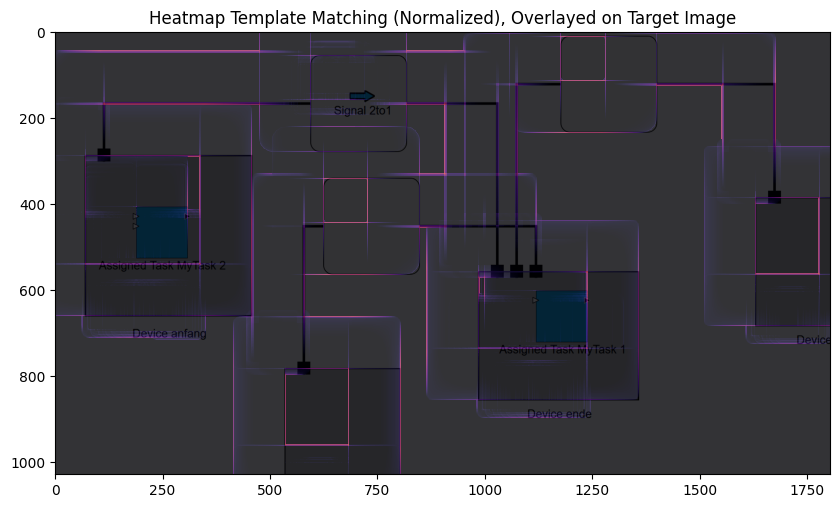

In [59]:
# Overlay the heatmap on the original image
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB))
ax.imshow(res, cmap='inferno', alpha=0.8, interpolation='nearest', vmin=0, vmax=1)  # `alpha` controls the transparency.
plt.title('Heatmap Template Matching (Normalized), Overlayed on Target Image')
plt.show()

#### Visualization of Template Matching 3D with plotly

In [60]:
# !! Danger !! plotly is expensive
if activate_plotly:
  fig = go.Figure(data=[go.Surface(z=res)])
  fig.update_layout(title='Heatmap Template Matching (Normalized)', 
                    scene=dict(
                      yaxis=dict(autorange='reversed') 
                    ), # This reverses the y-axis in a 3D plot
                    height=1500)
  fig.show()

#### Visualization of Template Matching 3D with plotly with screenshot for paper

In [61]:
template_matching_result_for_plot = res.copy()

if activate_plotly:
  fig = go.Figure()
  
  # Layer 1: 3D Plot of Heatmap
  fig.add_trace(go.Surface(
    z=template_matching_result_for_plot,
    showscale=False,
    ))

  # Layer 2: 2D Plot of Target Image at 0.1 (for aesthetics)
  # crop target image to the size of the heatmap
  target_img_cropped = target_img[:template_matching_result_for_plot.shape[0], :template_matching_result_for_plot.shape[1], :]
  # convert to grayscale (color seems to be tricky)
  target_img_cropped_gray = cv2.cvtColor(target_img_cropped, cv2.COLOR_BGR2GRAY)
  z_image = np.ones_like(target_img_cropped_gray)*0.1
  
  fig.add_trace(go.Surface(
    z=z_image, 
    surfacecolor=target_img_cropped_gray, 
    colorscale='gray', 
    showscale=False))

  fig.update_layout(title='Heatmap Template Matching (Normalized)', 
                    scene=dict(
                      yaxis=dict(autorange='reversed') 
                    ), # This reverses the y-axis in a 3D plot    --- use this, super good!
                    scene_aspectratio=dict(x=2, y=1, z=0.5),
                    height=1500)
  fig.show()

## Thresholding

### Histogram for Thresholding

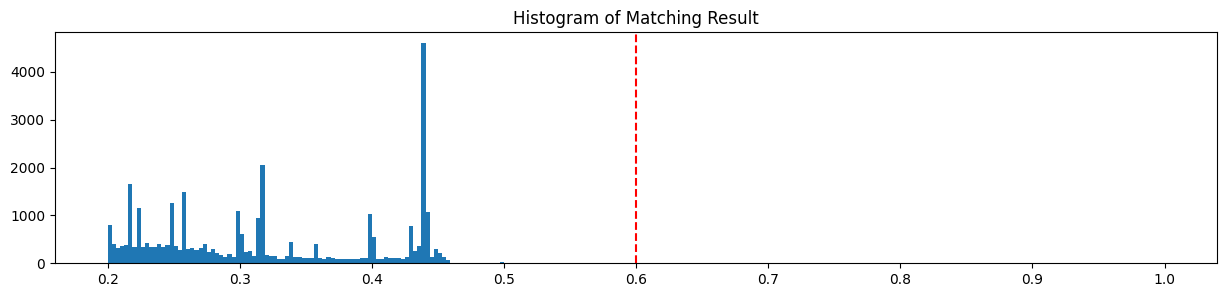

In [62]:

# Draw histogram of the results
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
ax.hist(res.ravel(), bins=256, range=[0.2, 1])
# visualize the threshold
ax.axvline(x=threshold, color='r', linestyle='--')
ax.set_title('Histogram of Matching Result')
plt.show()

### Threshold Template Matching

In [63]:
loc = np.where(res >= threshold)
print(f"Found {len(loc[0])} matches with a threshold of {threshold}")

Found 1 matches with a threshold of 0.6


## Visualization after Thresholding

### Analysis After Thresholding

In [64]:
# Set all values below the threshold to 0
thresholded_res = np.copy(res)
thresholded_res[thresholded_res < threshold] = 0

### 2D Visualization

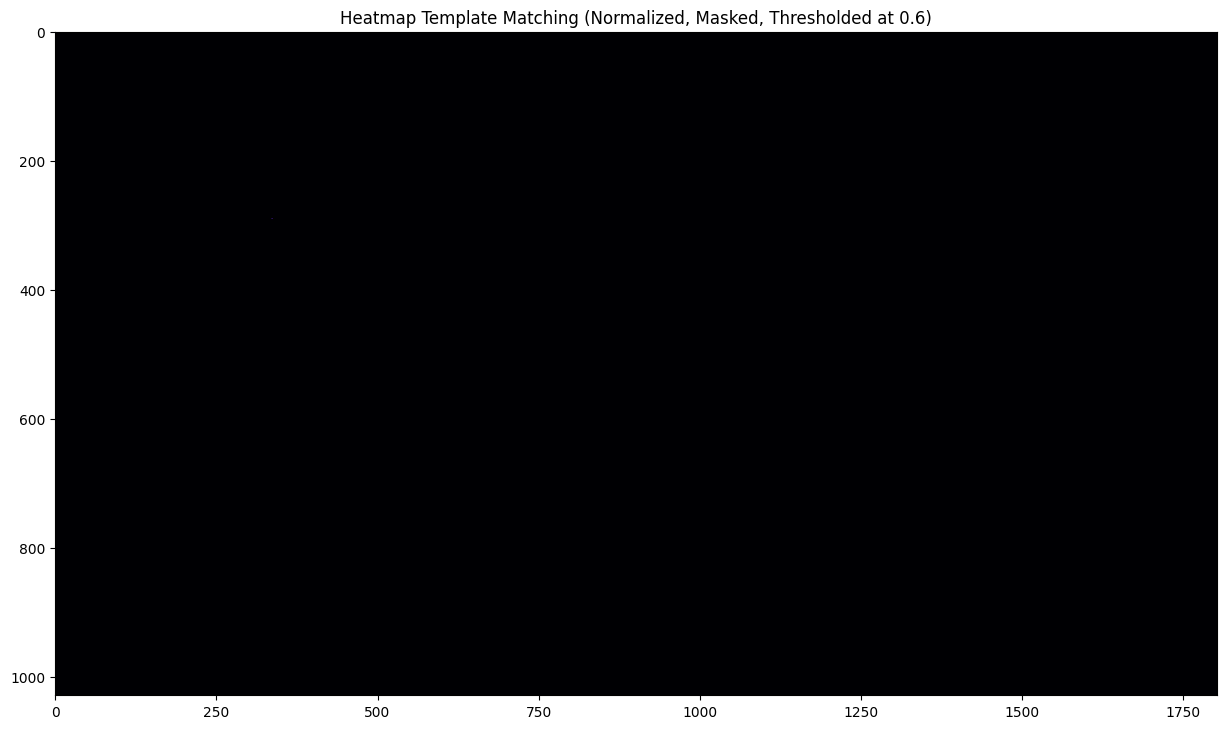

In [65]:
# Draw the thresholded results
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
cax = ax.imshow(loc, cmap='inferno', vmin=0, vmax=1)
ax.imshow(thresholded_res, cmap='inferno', vmin=0, vmax=1)
ax.set_title(f'Heatmap Template Matching (Normalized, Masked, Thresholded at {threshold})')
# fig.colorbar(cax, ax=ax) # optional colorbar
plt.show()

### 2D on Target Image

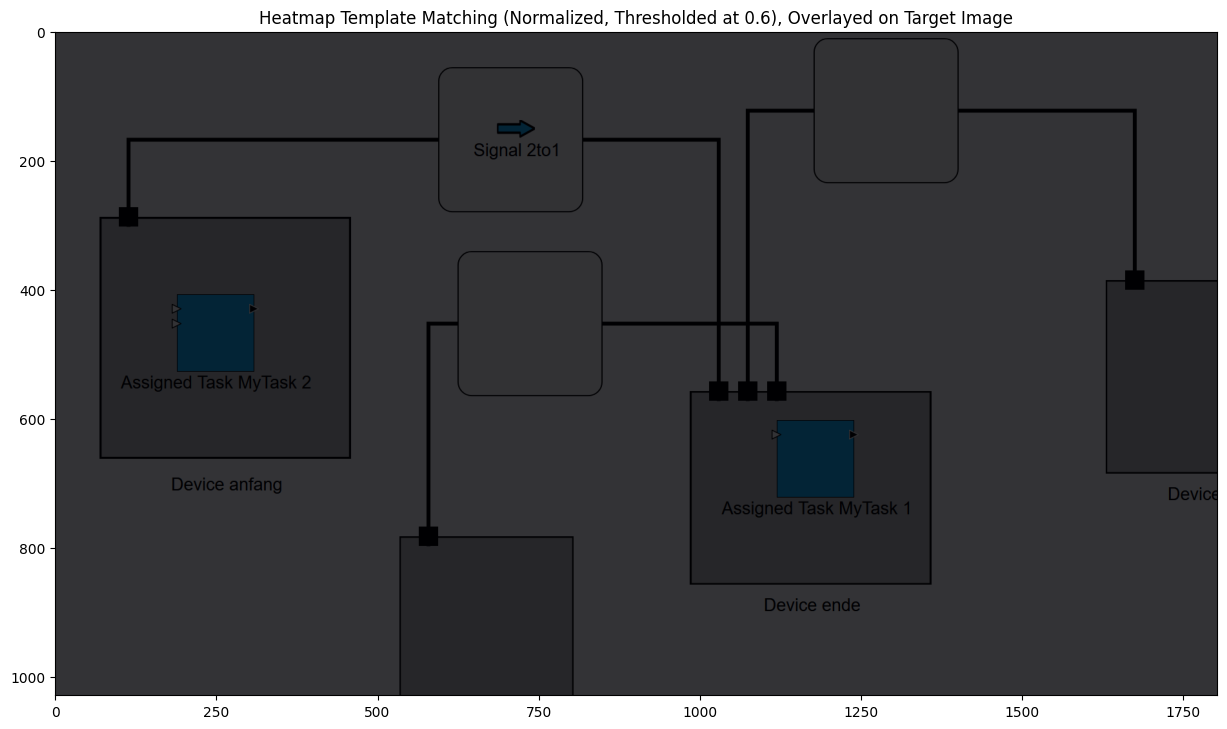

In [66]:
# Overlay the heatmap on the original image
plt.figure(figsize=(15,10))
plt.imshow(cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB))
plt.imshow(thresholded_res, cmap='inferno', alpha=0.8, interpolation='nearest', vmin=0, vmax=1)  # `alpha` controls the transparency.
plt.title(f'Heatmap Template Matching (Normalized, Thresholded at {threshold}), Overlayed on Target Image')
plt.show()


#### 2D big Xes on Target Image
Xes are easy to see, but their color does not provide a colorscale

TODO: add this visualization to actual code base

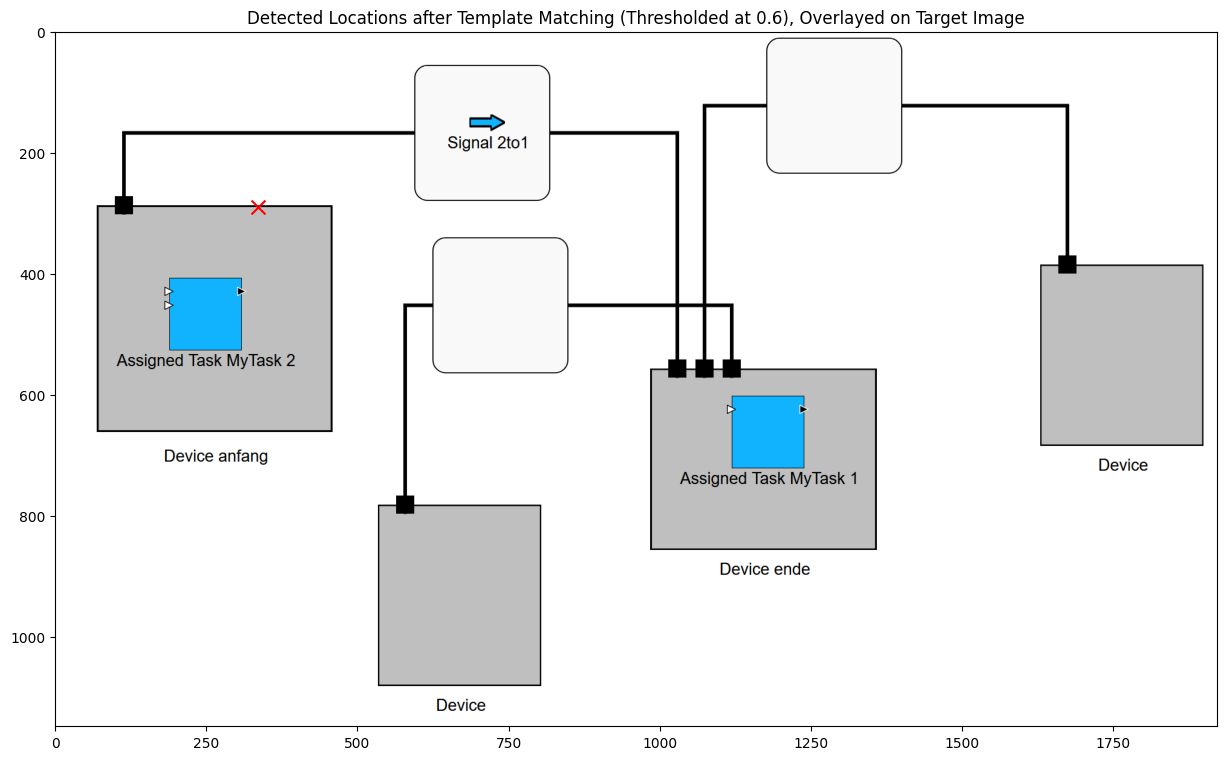

In [67]:
# draw the loc as points
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.imshow(cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB))
ax.scatter(loc[1], loc[0], c='r', s=100, marker='x')
plt.title(f'Detected Locations after Template Matching (Thresholded at {threshold}), Overlayed on Target Image')
plt.show()

### 3D with Plotly

In [68]:
if activate_plotly: # not as expensive anymore, way less pixels
  fig = go.Figure(
    data=[go.Surface(
      z=thresholded_res)]
    )
  fig.update_layout(title=f'Heatmap Template Matching (Normalized, Thresholded at {threshold})', 
                    scene=dict(
                      zaxis=dict(range=[threshold, 1]),
                      yaxis=dict(autorange='reversed'), # This reverses the y-axis in a 3D plot    --- use this, super good!
                    ), 
                    height=1200)
  fig.show()

### 2D with Plotly

In [69]:
# again with plotly, but 2D
if activate_plotly:
  fig = go.Figure(
    data=go.Heatmap(
      z=thresholded_res,
      ),
    )
  fig.update_layout(title='Heatmap Template Matching (Normalized, Thresholded)', 
                    scene=dict(
                      yaxis=dict(autorange='reversed') 
                    ), # This reverses the y-axis in a 3D plot    --- use this, super good!
                    height=1200)
  fig.show()


## From Pixels to Boxes

### Bounding Boxes before Foreground check
Draw bounding boxes for every single matched template. (A 180x200 box for every single pixel)

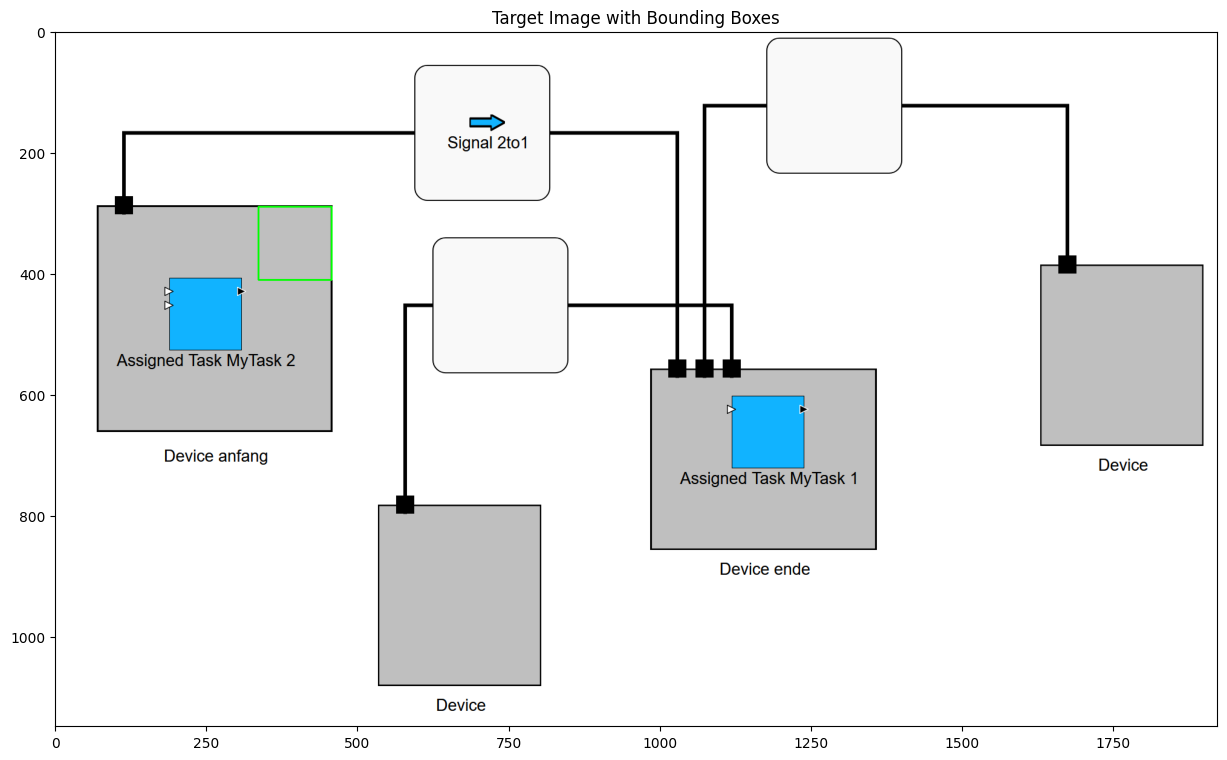

In [70]:
# Draw the bounding boxes
target_img_with_boxes = target_img.copy()
for pt in zip(*loc[::-1]):
    bottom_right = (pt[0] + template_img.shape[1], pt[1] + template_img.shape[0])
    cv2.rectangle(target_img_with_boxes, pt, bottom_right, (0, 255, 0), 2)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.imshow(cv2.cvtColor(target_img_with_boxes, cv2.COLOR_BGR2RGB))
plt.title('Target Image with Bounding Boxes')  
plt.show()

### Threshold to get Foreground
Original target image is thresholded to get foreground. This is used to restrict matches to the foreground. TODO: is this still a thing?

In [71]:
# Convert to grayscale
target_gray = cv2.cvtColor(target_img, cv2.COLOR_BGR2GRAY)

# Threshold the image
_, target_thresh = cv2.threshold(target_gray, 245, 255, cv2.THRESH_BINARY_INV)

### Visualize Foreground

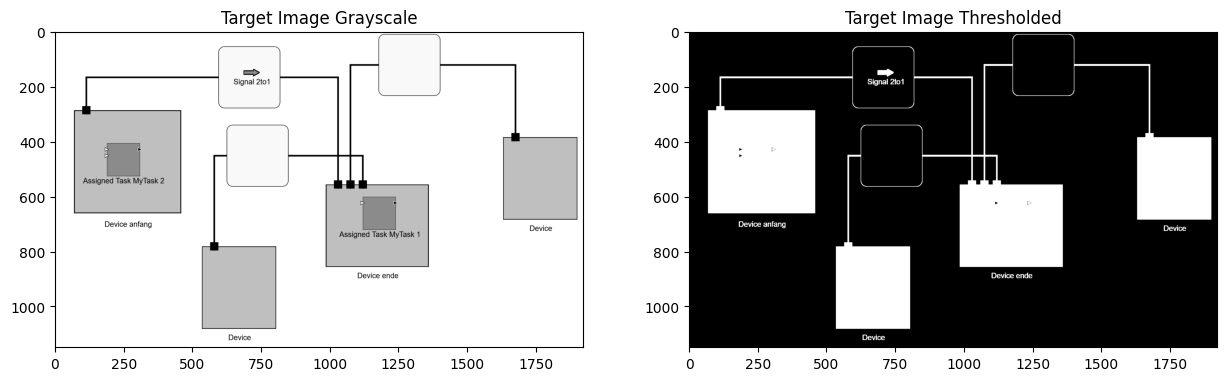

In [72]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(target_gray, cmap='gray')
ax[0].set_title('Target Image Grayscale')
ax[1].imshow(target_thresh, cmap='gray')
ax[1].set_title('Target Image Thresholded')
plt.show()

### Filter Foreground
Filters the bounding boxes of the vertices. Only locations in the foreground are kept. This is probably obsolete. 

In [73]:
loc_foreground = []
for pt in zip(*loc[::-1]):
    if np.all(target_thresh[pt[1]:pt[1] + template_img.shape[0], pt[0]:pt[0] + template_img.shape[1]] == 255):
        loc_foreground.append(pt)

### Visualize Bounding Boxes after Foreground Filtering

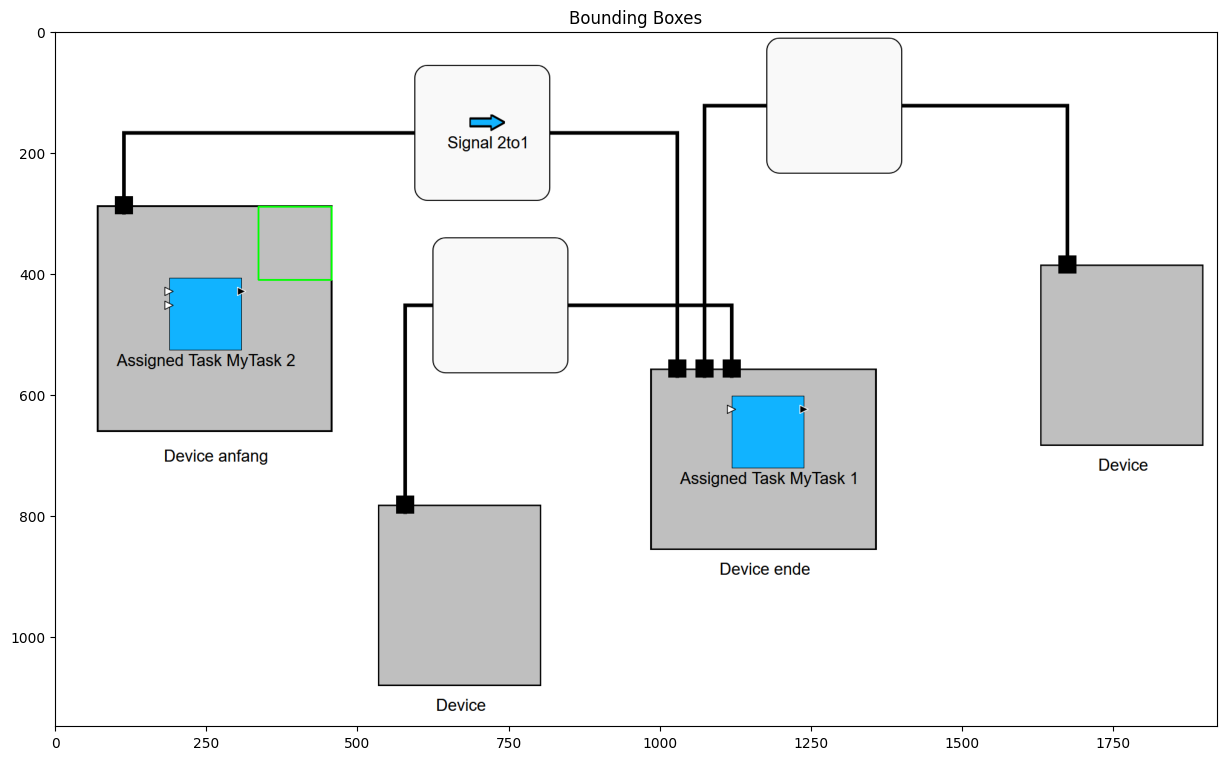

In [74]:
target_img_bounding_boxes = target_img.copy()
for pt in zip(*loc[::-1]):
    cv2.rectangle(target_img_bounding_boxes, pt, (pt[0] + template_img.shape[1], pt[1] + template_img.shape[0]), (0, 255, 0), 2)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.imshow(cv2.cvtColor(target_img_bounding_boxes, cv2.COLOR_BGR2RGB))
ax.set_title('Bounding Boxes')
plt.show()

### Analyse Foreground Check
Foregound check has currently negligible effect and could be deactivated.

In [75]:
# Compare loc and loc_foreground
print(f"Found {len(loc[0])} matches with a threshold of {threshold}")
print(f"Found {len(loc_foreground)} matches with a threshold of {threshold} and foreground filter")

Found 1 matches with a threshold of 0.6
Found 1 matches with a threshold of 0.6 and foreground filter


#### Visualize Remaining Matches after Foreground Filter

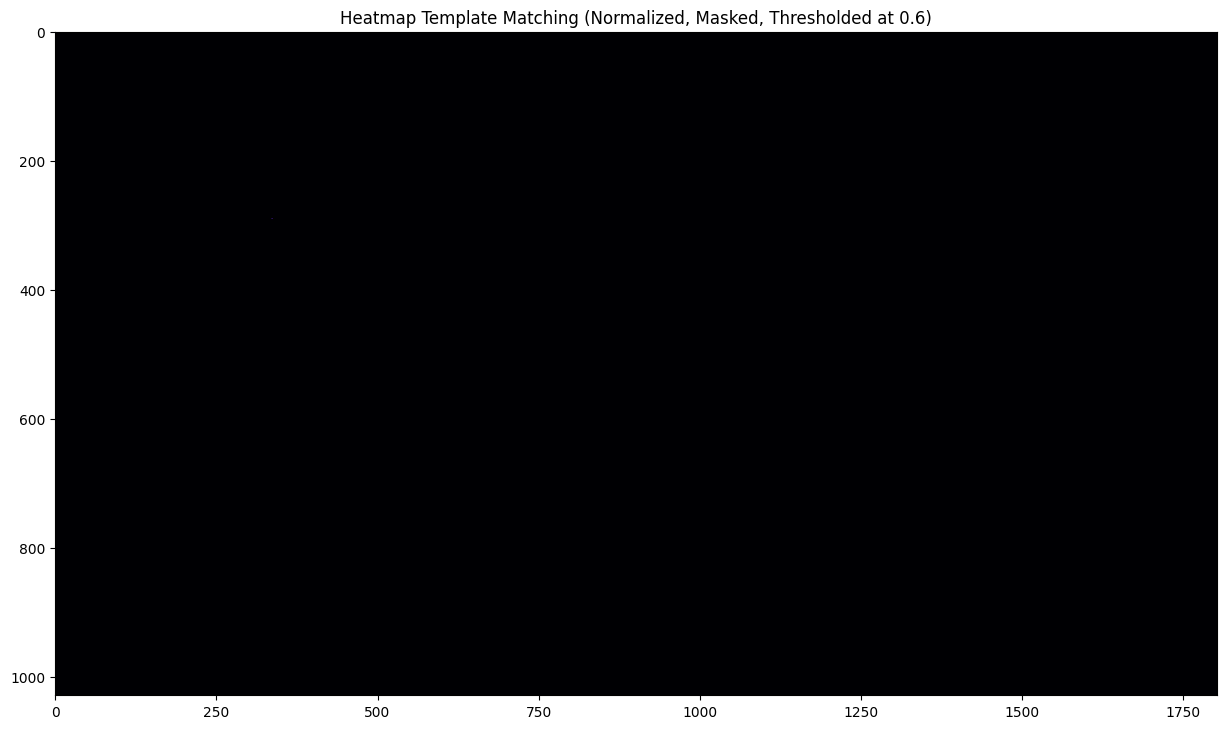

In [76]:
# Set all values below the threshold to 0
thresholded_res = np.copy(res)
thresholded_res[thresholded_res < threshold] = 0

# Draw the thresholded results
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
cax = ax.imshow(loc, cmap='inferno', vmin=0, vmax=1)
ax.imshow(thresholded_res, cmap='inferno', vmin=0, vmax=1)
ax.set_title(f'Heatmap Template Matching (Normalized, Masked, Thresholded at {threshold})')
# fig.colorbar(cax, ax=ax) # optional colorbar
plt.show()

#### ... on Target Image

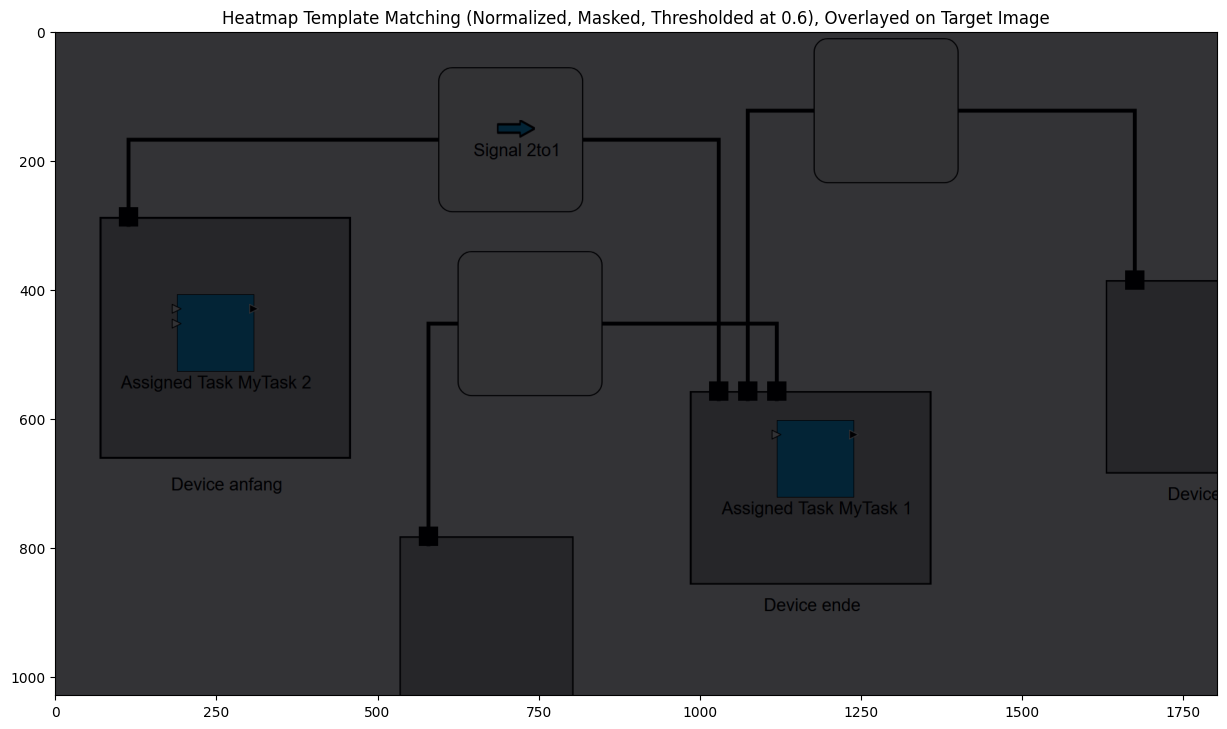

In [77]:
# Overlay the heatmap on the original image
plt.figure(figsize=(15,10))
plt.imshow(cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB))
plt.imshow(thresholded_res, cmap='inferno', alpha=0.8, interpolation='nearest', vmin=0, vmax=1)  # `alpha` controls the transparency.
plt.title(f'Heatmap Template Matching (Normalized, Masked, Thresholded at {threshold}), Overlayed on Target Image')
plt.show()

Idea. To distinguish between differently coloured boxes do comparison above the threshold which coloured box gets the most points. Old idea. It is easier if it finds every box with confidence. 

### Fill bounding boxes
Fills the bounding boxes of the vertices

In [78]:
matched_templates_bbox_filled = np.zeros(target_img.shape[:2], dtype=np.uint8)
for pt in loc_foreground:
    cv2.rectangle(matched_templates_bbox_filled, pt, (pt[0] + template_img.shape[1], pt[1] + template_img.shape[0]), 255, -1)

#### Plot filled bounding boxes

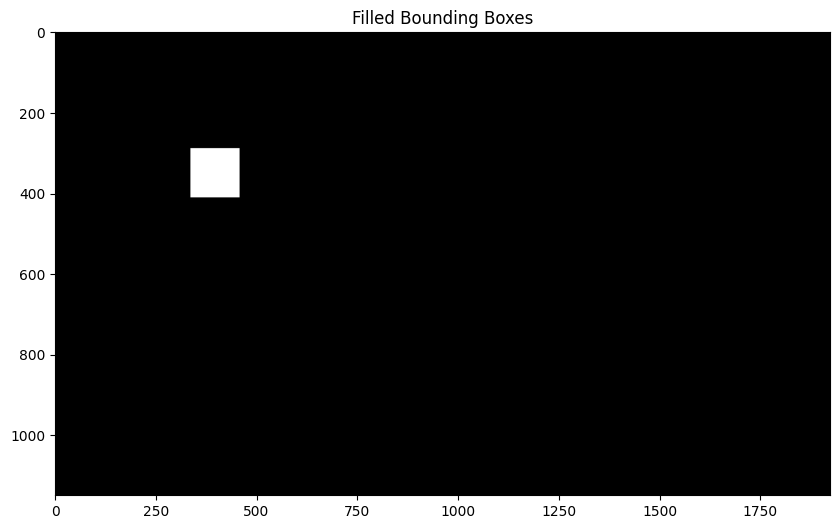

In [79]:
# Draw the filled bounding boxes
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(matched_templates_bbox_filled, cmap='gray')
ax.set_title('Filled Bounding Boxes')
plt.show()

### Find Contours in the super boxes
The overlapping bounding boxes are now puzzled together to big boxes

In [80]:
target_img_boundings_grouped = target_img.copy()

# Find contours
contours, _ = cv2.findContours(matched_templates_bbox_filled, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Store the bounding boxes of the vertices
bounding_boxes = []

# Draw bounding boxes based on contours and save their coordinates
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    cv2.rectangle(target_img_boundings_grouped, (x, y), (x+w, y+h), (0, 255, 0), 4)
    bounding_boxes.append((x, y, w, h))
print(f"bounding_boxes: {bounding_boxes}")

bounding_boxes: [(336, 290, 122, 122)]


#### Visualize the super boxes

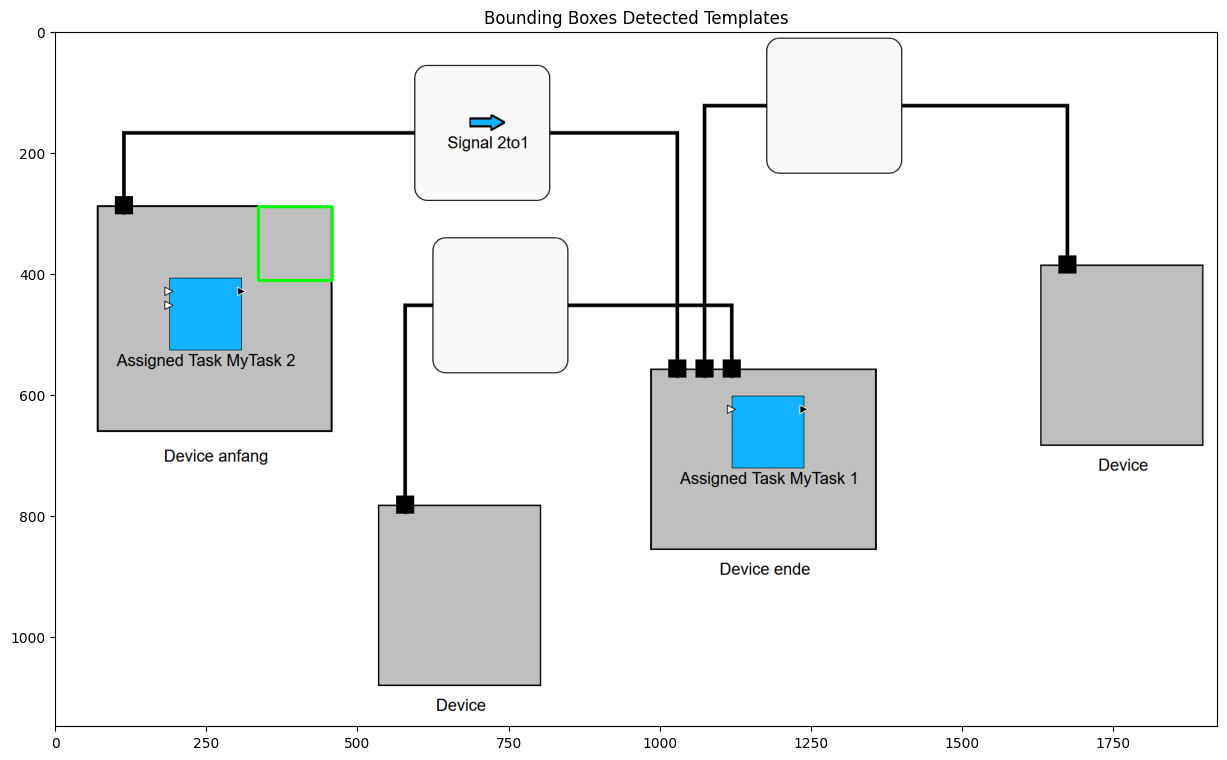

In [81]:
# Draw the result
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.imshow(cv2.cvtColor(target_img_boundings_grouped, cv2.COLOR_BGR2RGB))
ax.set_title("Bounding Boxes Detected Templates")
plt.show()
